In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.datasets import load_diabetes
from holisticai.datasets import load_us_crime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import regression_efficacy_metrics

In [3]:
dataset = load_us_crime(return_X_y=False, as_frame=True)
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8.0,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53.0,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24.0,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34.0,5.0,81440.0,Willingborotownship,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42.0,95.0,6096.0,Bethlehemtownship,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [4]:
def preprocess_us_crime_dataset(df, protected_feature):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean[protected_feature].apply(lambda x: x>0.5)
  group_b =  1-group_a
  group_b = group_b.astype('bool')
  # Remove unnecessary columns
  cols = [c for c in df_clean.columns if (not c.startswith('race')) and (not c.startswith('age'))]
  df_clean = df_clean[cols].iloc[:,3:]
  return df_clean, group_a, group_b

In [5]:
df_clean, group_a, group_b = preprocess_us_crime_dataset(df, 'racePctWhite')
X = df_clean.iloc[:,:-1]
y = df_clean.iloc[:,-1]

<Axes: >

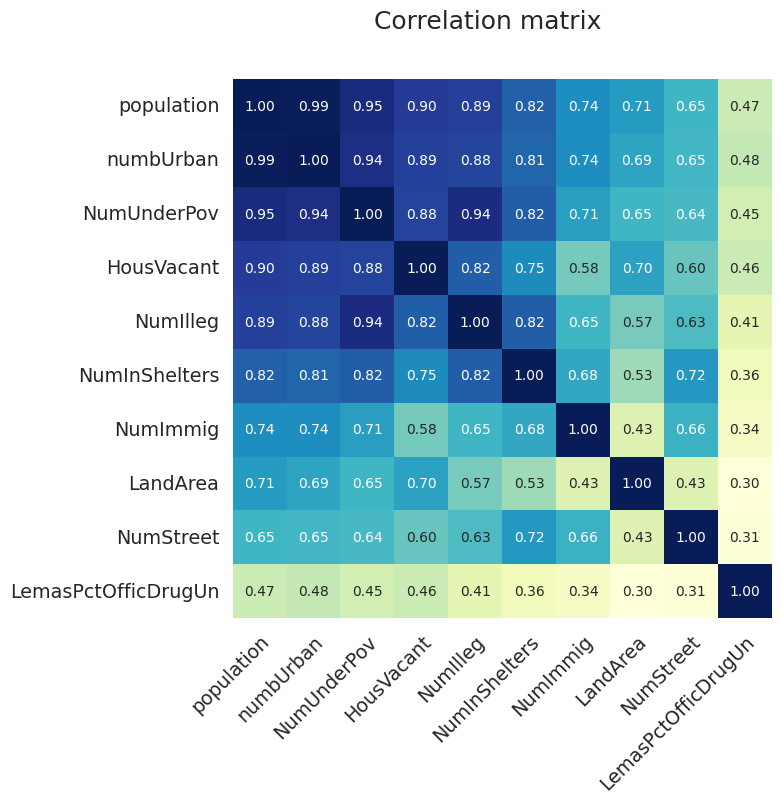

In [6]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='population', size = (12,7))

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = GradientBoostingRegressor() # instantiate model
#model = LinearRegression()
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
regression_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
RMSE,1.396764e-01,0
MAE,9.038879e-02,0
MAPE,1.185104e+12,0
Max Error,7.651164e-01,0
SMAPE,2.367336e-01,0


In [8]:
# permutation feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [9]:
explainer.metrics()

,Value,Reference
Fourth Fifths,0.641304,0
Importance Spread Divergence,0.310633,-
Importance Spread Ratio,0.931303,0
Global Overlap Score,0.042786,1
Global Range Overlap Score,0.444978,1
Global Similarity Score,0.606342,1
Global Explainability Ease Score,0.565217,1


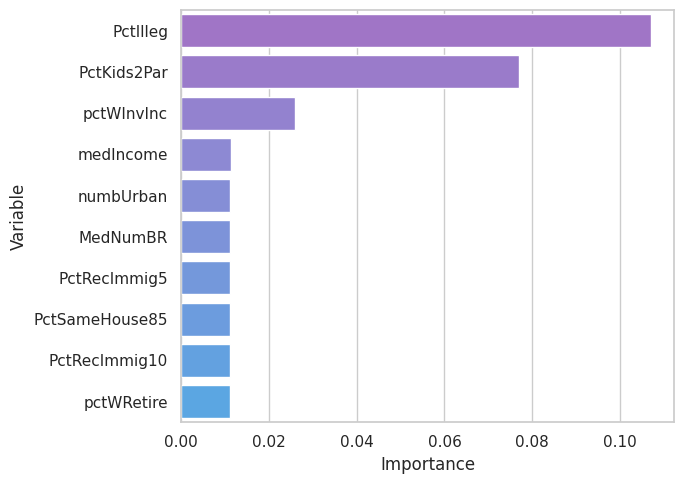

In [10]:
explainer.bar_plot(max_display=10)

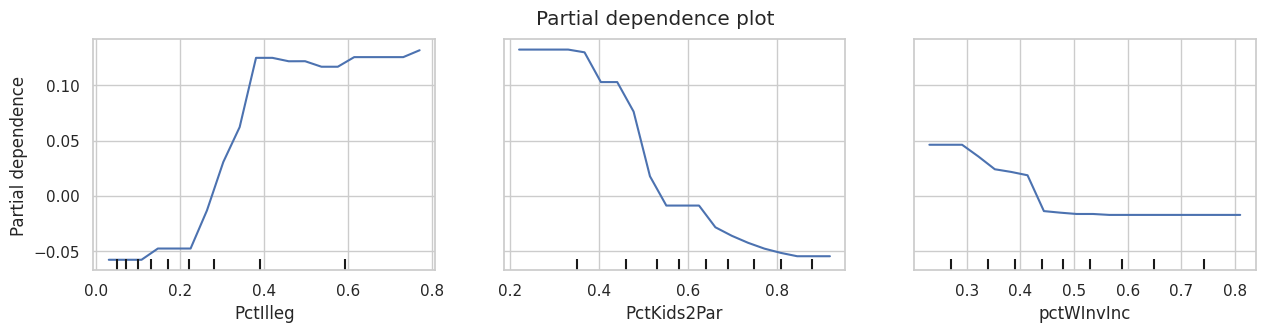

In [11]:
_,ax = plt.subplots(figsize=(15,3))
explainer.partial_dependence_plot(last=3, ax=ax)

Conditional Feature Importance Metrics

In [12]:
explainer.metrics(detailed=True)

,Value,Reference
Fourth Fifths,0.641304,0
Importance Spread Divergence,0.310633,-
Importance Spread Ratio,0.931303,0
Global Overlap Score [Q0-Q1],0.005750,1
Global Overlap Score [Q1-Q2],0.000000,1
Global Overlap Score [Q2-Q3],0.109910,1
Global Overlap Score [Q3-Q4],0.055483,1
Global Range Overlap Score [Q0-Q1],0.441518,1
Global Range Overlap Score [Q1-Q2],0.450520,1
Global Range Overlap Score [Q2-Q3],0.462315,1


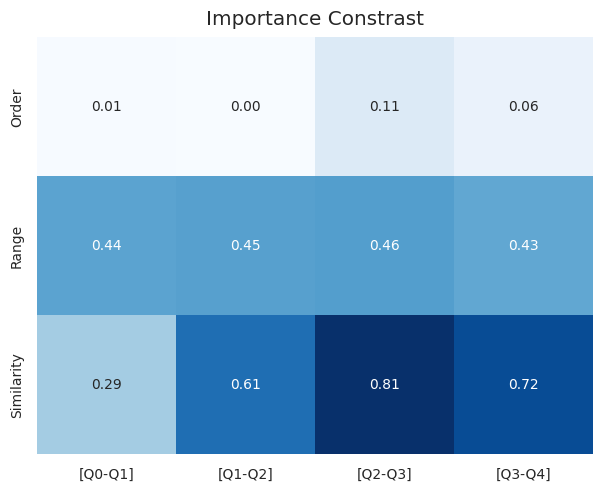

In [13]:
# How change the feature importance for each quantil with respect to the feature importance of the whole model?
explainer.contrast_visualization(show_connections=False)

In [14]:
explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[Q0-Q1] Importance,[Q1-Q2] Importance,[Q2-Q3] Importance,[Q3-Q4] Importance
Variable,,,,,
PctIlleg,0.106979,0.007455,0.066781,0.126036,0.116799
PctKids2Par,0.077025,0.009583,0.063301,0.092722,0.076164
pctWInvInc,0.025950,0.088453,0.050305,0.026890,0.009787
medIncome,0.011319,0.000000,0.000000,0.000000,0.000077
PctRecImmig5,0.011216,0.000000,0.000000,0.000000,0.000000


# Global Explainability metrics (based on Surrogate Model)

In [15]:
# surrogate feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [16]:
explainer.metrics()

,Value,Reference
Fourth Fifths,0.010870,0
Importance Spread Divergence,3.463653,-
Importance Spread Ratio,0.234008,0
Global Explainability Ease Score,0.565217,1
Surrogate Efficacy Regression,0.259607,0


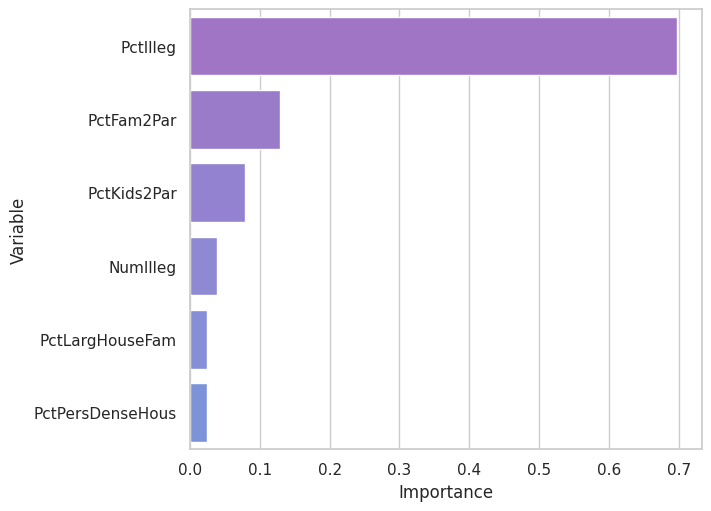

In [17]:
explainer.bar_plot(max_display=6)

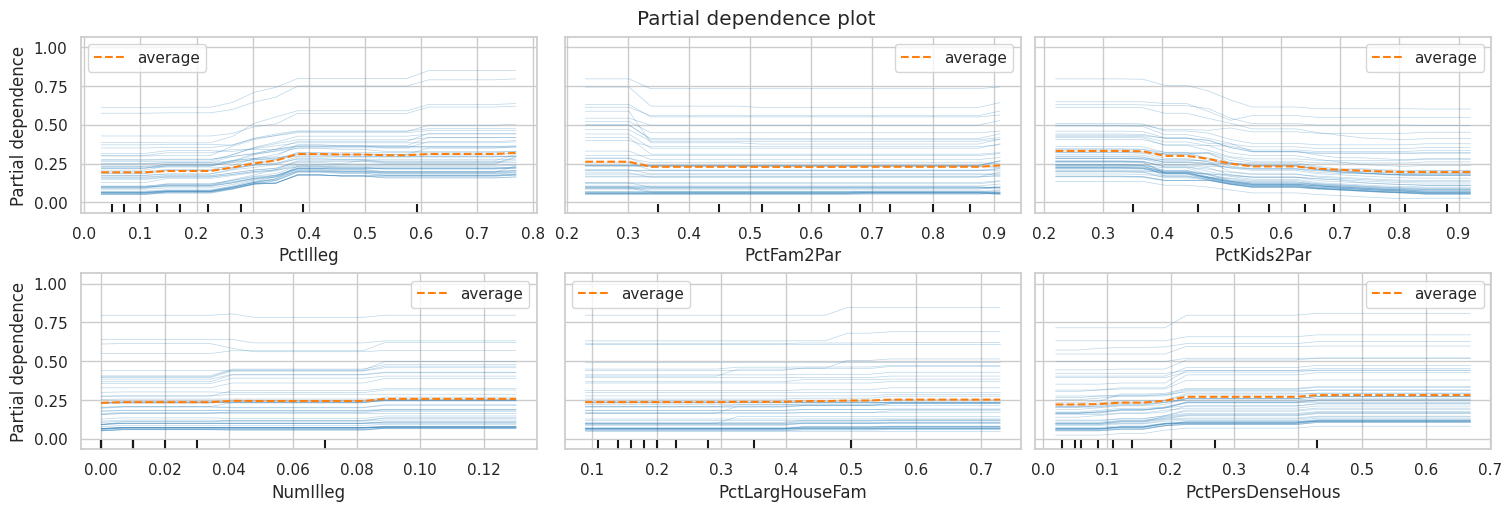

In [18]:
_,ax = plt.subplots(figsize=(15,5))
explainer.partial_dependence_plot(last=6, ax=ax, kind='both')

In [19]:
explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
PctIlleg,0.697821
PctFam2Par,0.128331
PctKids2Par,0.078922
NumIlleg,0.038126
PctLargHouseFam,0.025040
PctPersDenseHous,0.024772
FemalePctDiv,0.006988
pctWSocSec,0.000000
pctWFarmSelf,0.000000


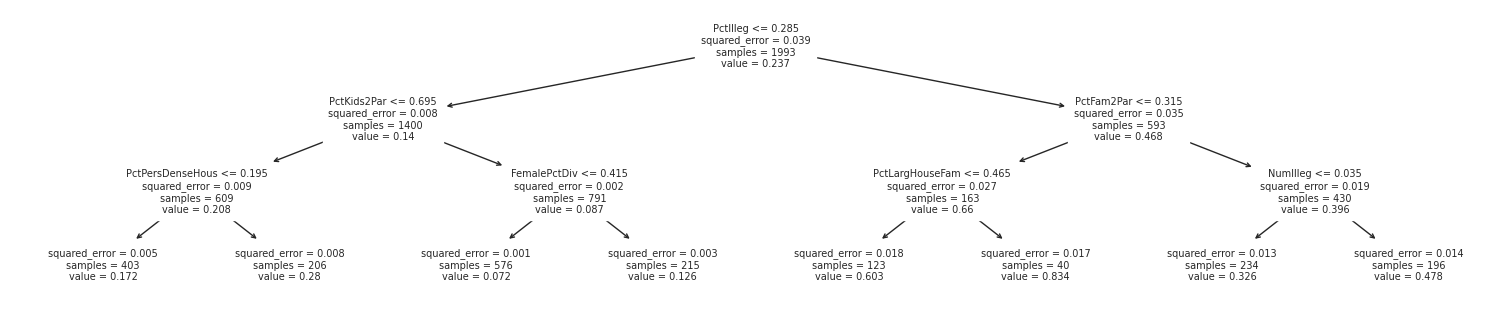

In [20]:
_,ax = plt.subplots(figsize=(15,3))
_ = explainer.tree_visualization('sklearn', fontsize=7, ax=ax)

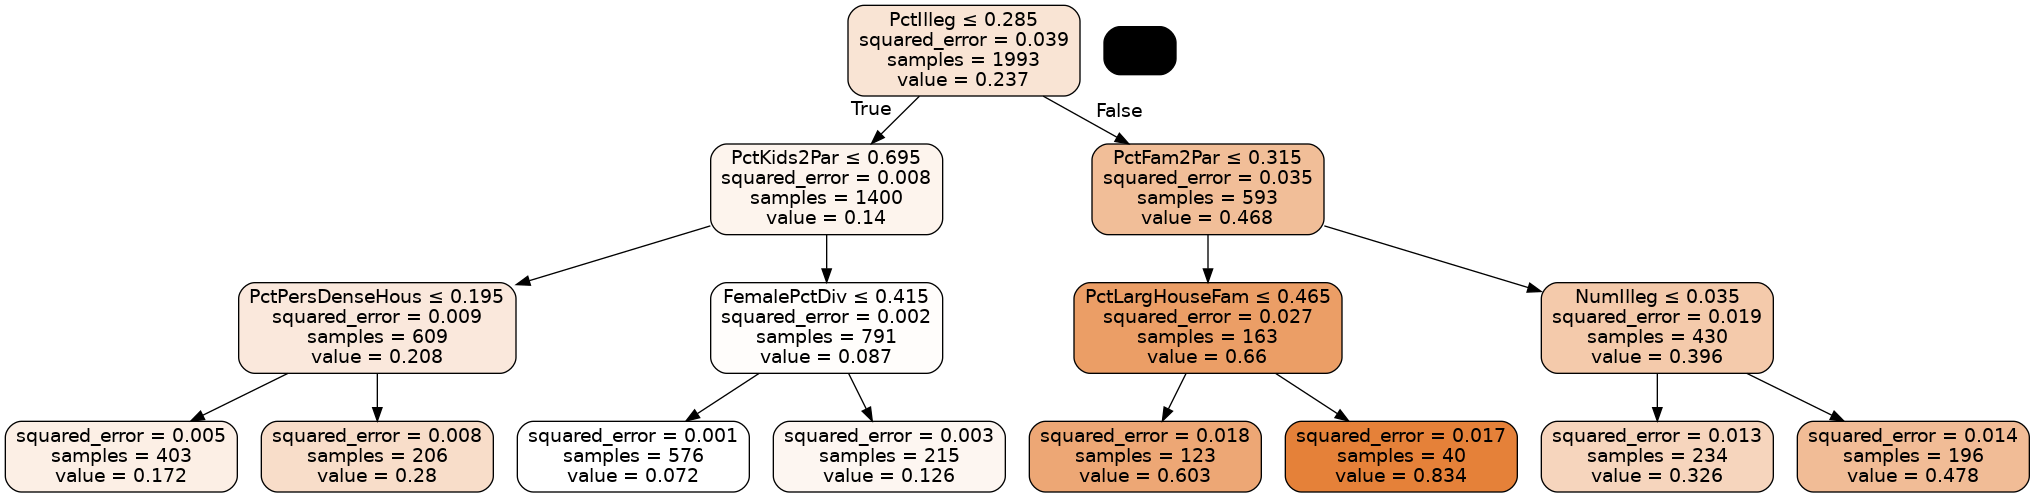

In [21]:
explainer.tree_visualization('pydotplus')

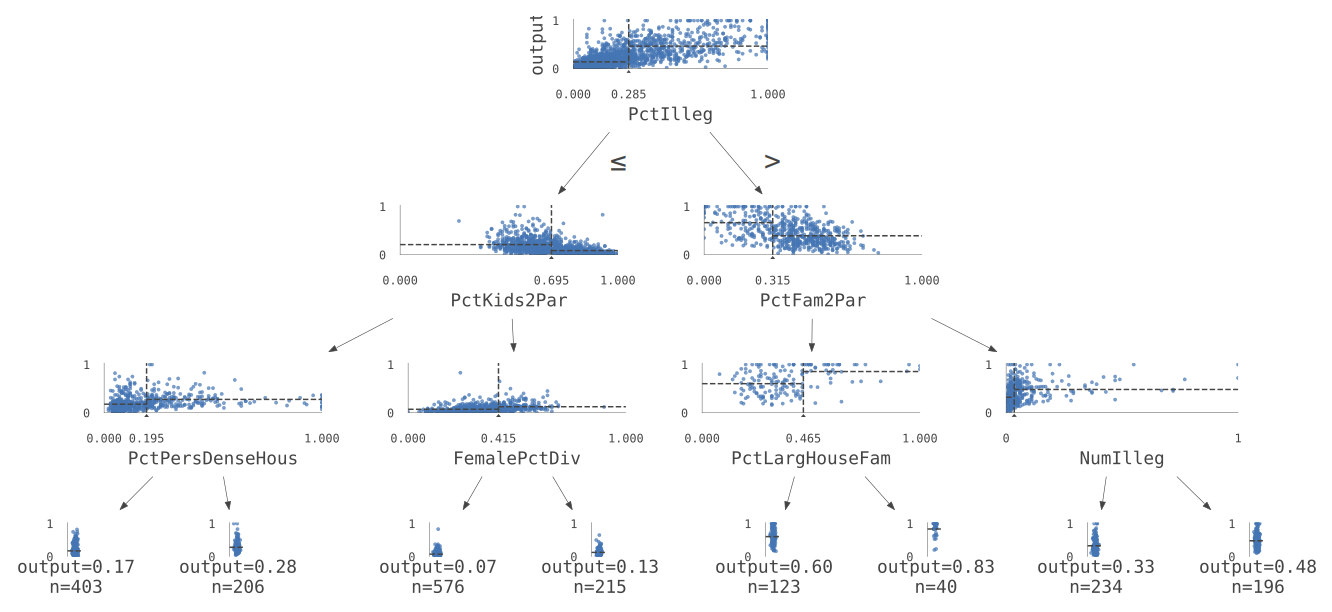

In [22]:
vis = explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [23]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

100%|██████████| 4/4 [01:22<00:00, 20.64s/it]


In [24]:
explainer.metrics()

,Value,Reference
Dataset Stability Gini,0.010676,0
Dataset Stability Mean,0.924597,0
Dataset Stability Ratio,0.999971,1
Features Stability Gini,0.001180,0
Features Stability Mean,0.959289,0
Features Stability Ratio,0.999999,1


In [25]:
explainer.metrics(detailed=True)

,value,Reference
Metric,,
Dataset Stability Gini Global,0.010676,0
Dataset Stability Gini [Q0-Q1],0.005360,0
Dataset Stability Gini [Q1-Q2],0.006270,0
Dataset Stability Gini [Q2-Q3],0.010205,0
Dataset Stability Gini [Q3-Q4],0.013522,0
Dataset Stability Mean Global,0.924597,0
Dataset Stability Mean [Q0-Q1],0.932518,0
Dataset Stability Mean [Q1-Q2],0.931909,0
Dataset Stability Mean [Q2-Q3],0.925786,0


In [26]:
#explainer.feature_importance_table(sorted_by='Global', top_n=10)

In [ ]:
lime_explainer.show_importance_stability()

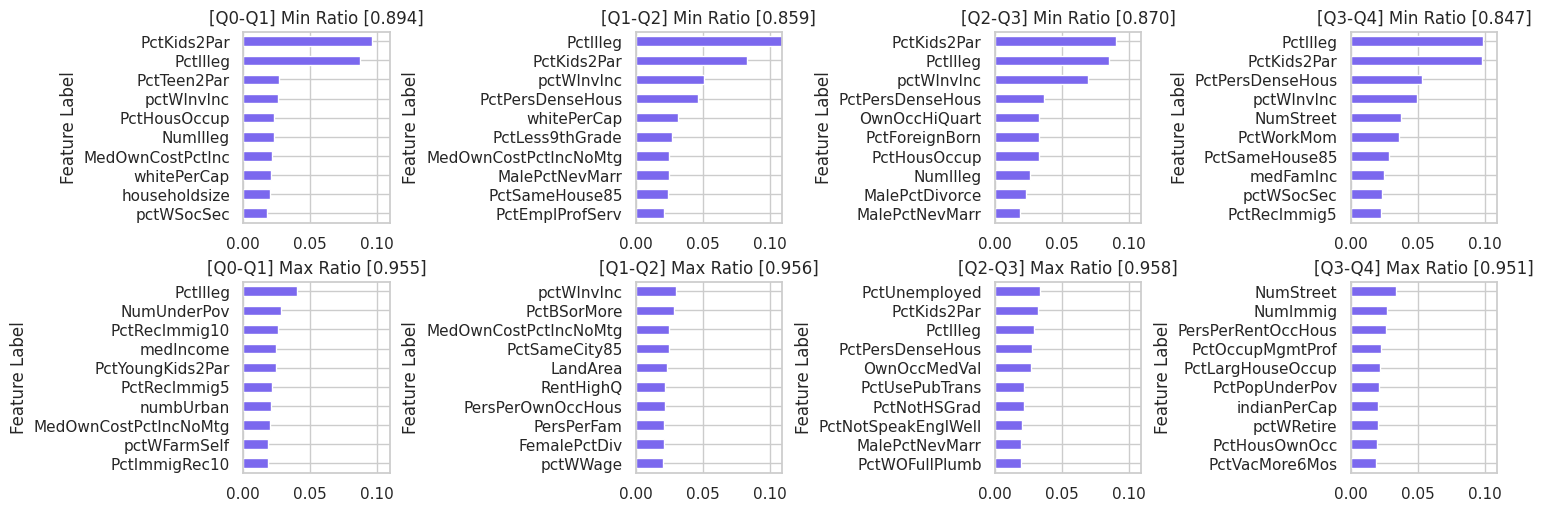

In [27]:
explainer.show_data_stability_boundaries(top_n=10, figsize=(15,5))

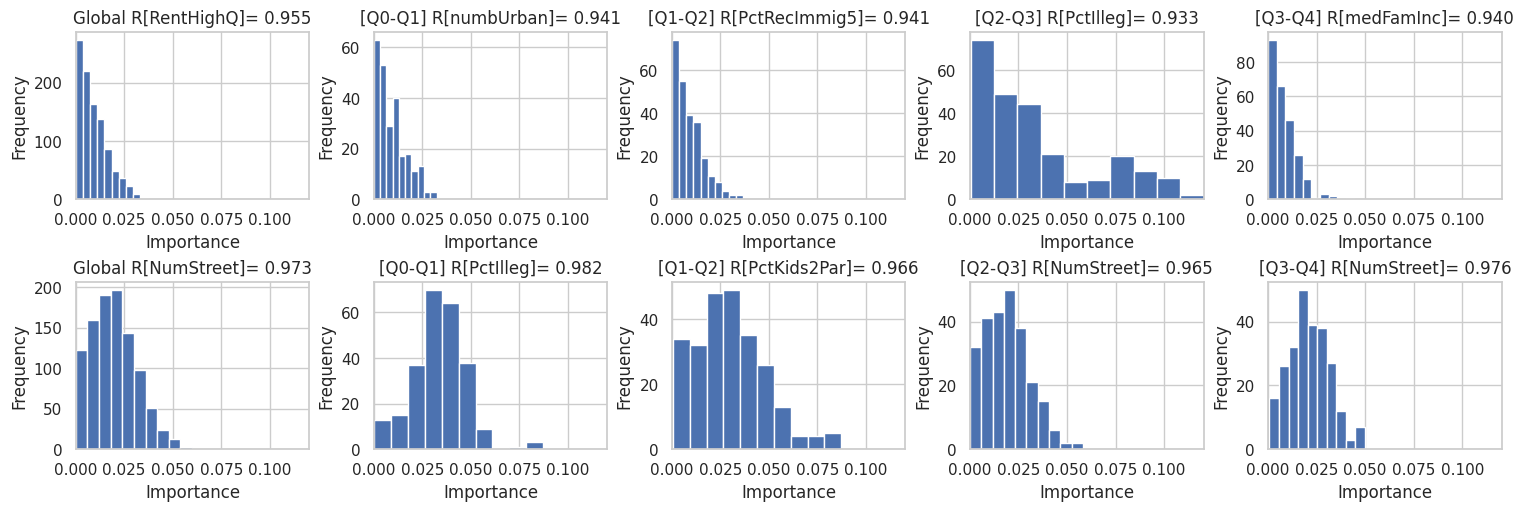

In [28]:
explainer.show_features_stability_boundaries(figsize=(15,5))